Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10

def extract(filename):
  #tar = tarfile.open(filename)
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  #print('Extracting data for %s. This may take a while. Please wait.' % root)
  #sys.stdout.flush()
  #tar.extractall()
  #tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
import random
#display(Image(url='http://www.google.fr/images/srpr/logo3w.png'))
examples = []
for letterdir in test_folders:    
    letters = os.listdir(letterdir)
    letter = os.path.join(letterdir, letters[int(len(letters)*random.random())])
    examples.append(letter)
    print(letterdir[len(letterdir)-1] + '(' + letter + ')')
    display(Image(filename=letter))

A(notMNIST_small/A/QnJlYWtiZWF0IEJUTiBPdXRsaW5lLnR0Zg==.png)


B(notMNIST_small/B/RmFnb05vVGYtTWVkaXVtQ2Fwcy5vdGY=.png)


C(notMNIST_small/C/Q29tc2F0LVN0YXRpb24ub3Rm.png)


D(notMNIST_small/D/QWxpeDIudHRm.png)


E(notMNIST_small/E/RGlnaUdyb3Rlc2tORUYtQm9sZENvbmRlbnMub3Rm.png)


F(notMNIST_small/F/QWt6aWRlbnpHcm90ZXNrQkUtTWQub3Rm.png)


G(notMNIST_small/G/RGVhclRlYWNoZXItTm9ybWFsLnR0Zg==.png)


H(notMNIST_small/H/QmVybnN0ZWluLURlbWlCb2xkLm90Zg==.png)


I(notMNIST_small/I/SVRDIEdvdWR5IFNhbnMgTGlnaHQucGZi.png)


J(notMNIST_small/J/QW1wbGl0dWRlQ29tcC1MaWdodC50dGY=.png)


Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images, min_examples_from_folder = 0):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print(folder + '(' + str(image_index) + ')')
    file_list = os.listdir(folder)
    if(min_examples_from_folder == 0):
        min_examples_from_folder = len(file_list) 
    for image in file_list[:min_examples_from_folder]:
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  #if num_images < min_num_images:
  #  raise Exception('Many fewer images than expected: %d < %d' % (
  #      num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels
#min_examples_from_folder == 0 means load all
train_dataset, train_labels = load(train_folders, 450000, 550000, 0)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A(0)
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/B(52909)
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/C(105820)
notMNIST_large/D(158732)
('Could not read:', 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/E(211643)
notMNIST_large/F(264555)
notMNIST_large/G(317467)
notMNIST_large/H(370379)
notMNIST_large/I(423291)
notMNIST_large/J(476203)
('Full dataset tensor:', (529114, 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

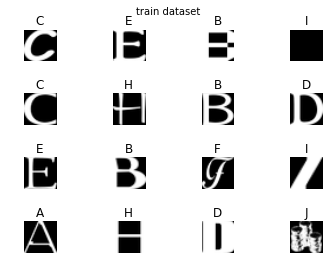

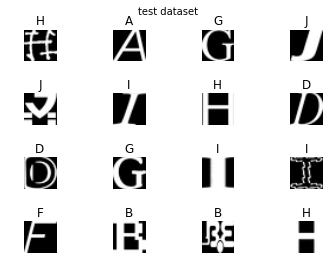

In [8]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

def display_sample(dataset, labels, title_label, model=None):    
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.3, hspace=1)
    fig = plt.figure()
    fig.suptitle(title_label)
    for d in range(0, 16):
        a=fig.add_subplot(gs[d])
        letter_idx = int(len(dataset)*random.random())
        #print(letter_idx)
        plt.imshow(dataset[letter_idx], cmap = cm.Greys_r)
        l_title = chr(labels[letter_idx] + ord('A'))
        if model is not None:
            l_title = l_title + ' / ~' + chr(model.predict(dataset[letter_idx].reshape(1, -1)) + ord('A'))
        a.set_title(l_title)
        a.axis('off')    
    plt.show()
    
display_sample(train_dataset, train_labels, 'train dataset')
display_sample(test_dataset, test_labels, 'test dataset')

#### Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [6]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

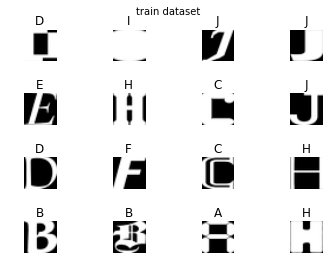

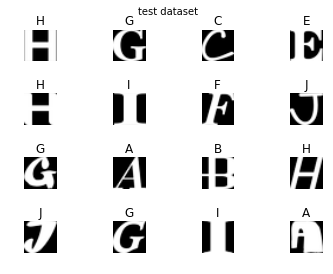

In [9]:
display_sample(train_dataset, train_labels, 'train dataset')
display_sample(test_dataset, test_labels, 'test dataset')

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [9]:
import scipy.stats as stats

print stats.itemfreq(train_labels)
print stats.itemfreq(test_labels)

[[  0.00000000e+00   5.29090000e+04]
 [  1.00000000e+00   5.29110000e+04]
 [  2.00000000e+00   5.29120000e+04]
 [  3.00000000e+00   5.29110000e+04]
 [  4.00000000e+00   5.29120000e+04]
 [  5.00000000e+00   5.29120000e+04]
 [  6.00000000e+00   5.29120000e+04]
 [  7.00000000e+00   5.29120000e+04]
 [  8.00000000e+00   5.29120000e+04]
 [  9.00000000e+00   5.29110000e+04]]
[[  0.00000000e+00   1.87200000e+03]
 [  1.00000000e+00   1.87300000e+03]
 [  2.00000000e+00   1.87300000e+03]
 [  3.00000000e+00   1.87300000e+03]
 [  4.00000000e+00   1.87300000e+03]
 [  5.00000000e+00   1.87200000e+03]
 [  6.00000000e+00   1.87200000e+03]
 [  7.00000000e+00   1.87200000e+03]
 [  8.00000000e+00   1.87200000e+03]
 [  9.00000000e+00   1.87200000e+03]]


Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [10]:
train_size = 469114
valid_size = 60000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)

('Training', (469114, 28, 28), (469114,))
('Validation', (60000, 28, 28), (60000,))


Finally, let's save the data for later reuse:

In [11]:
def save_pickle(name, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
    #will use global variables for datasets and labels. sorry
    pickle_file = name + '.pickle'

    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)      
      f.close()
      statinfo = os.stat(pickle_file)
      print('Compressed pickle size:', statinfo.st_size)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

In [12]:
#save original pickle
save_pickle('notMNISTfull', train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)

('Compressed pickle size:', 1720211761)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [13]:
#count duplicates by hashing
def check_duplicates(dataset, hashes=None):
    if hashes is None:
        hashes = {}
    total = 0
    dups = 0
    dataset.flags.writeable = False
    for letter in dataset:
        h = hash(letter.data)
        total = total + 1
        if(h in hashes):
            dups = dups + 1
        else:
            hashes[h] = h
    print('enumerated elements:' + str(total))
    print('duplicates:' + str(dups) + ' which is ' + str(dups*100.0/total) + '%')
    return hashes

#check test dataset against training
hashes = check_duplicates(train_dataset)
print('check validation dataset against training')
hashes = check_duplicates(valid_dataset, hashes)
print('now check test dataset against training')
hashes = check_duplicates(test_dataset, hashes)

enumerated elements:300000
duplicates:25409 which is 8.46966666667%
check validation dataset against training
enumerated elements:60000
duplicates:9278 which is 15.4633333333%
now check test dataset against training
enumerated elements:18724
duplicates:3909 which is 20.8769493698%


enumerated elements:300000
removed duplicates:25409 which is 8.46966666667%
dedup sizes (set/labels): 274591/274591


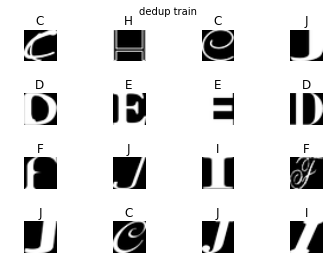

enumerated elements:60000
removed duplicates:9278 which is 15.4633333333%
dedup sizes (set/labels): 50722/50722


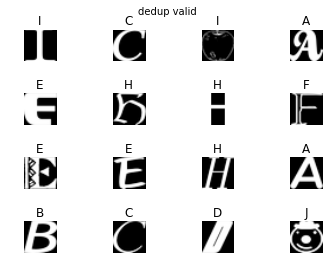

enumerated elements:18724
removed duplicates:3909 which is 20.8769493698%
dedup sizes (set/labels): 14815/14815


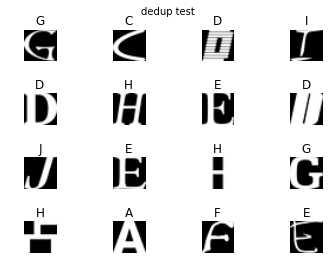

('Compressed pickle size:', 1068002361)


In [14]:
def deduplicate(dataset, labels, hashes=None):
    if hashes is None:
        hashes = {}
    #create deduplicated empty arrays
    #dedup_dataset = np.empty((0, dataset.shape[1], dataset.shape[2]))
    #dedup_labels = np.empty((0))
    unique_values = []
    unique_labels = []
    i = 0
    dups = 0
    dataset.flags.writeable = False
    while i < dataset.shape[0]:
        letter = dataset[i]    
        h = hash(letter.data)        
        if(h in hashes):
            dups = dups + 1
        else:
            hashes[h] = h
            unique_values.append(letter)
            unique_labels.append(labels[i])
            #np.append(dedup_dataset, [letter], axis=0)
            #np.append(dedup_labels, labels[i], axis=0)
        i = i + 1
    dedup_dataset = np.array(unique_values)
    dedup_labels = np.array(unique_labels)
    print('enumerated elements:' + str(i))
    print('removed duplicates:' + str(dups) + ' which is ' + str(dups*100.0/i) + '%')
    print('dedup sizes (set/labels): ' + str(dedup_dataset.shape[0]) + '/' + str(dedup_labels.shape[0]))
    
    return dedup_dataset, dedup_labels, hashes
    
dedup_train_dataset, dedup_train_labels, hashes = deduplicate(train_dataset, train_labels)
display_sample(dedup_train_dataset, dedup_train_labels, 'dedup train')
dedup_valid_dataset, dedup_valid_labels, hashes = deduplicate(valid_dataset, valid_labels, hashes)
display_sample(dedup_valid_dataset, dedup_valid_labels, 'dedup valid')
dedup_test_dataset, dedup_test_labels, hashes = deduplicate(test_dataset, test_labels, hashes)
display_sample(dedup_test_dataset, dedup_test_labels, 'dedup test')

#save dedup pickle
save_pickle('notMNISTdedup', dedup_train_dataset, dedup_train_labels, dedup_valid_dataset,
            dedup_valid_labels, dedup_test_dataset, dedup_test_labels)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
#train model

def train_models(models, dataset, labels):
    #reshape train dataset so 2d image is an 1d list of features
    dataset_f = dataset.reshape((dataset.shape[0],-1))
    #print(train_dataset[0])
    #train_dataset.reshape((train_dataset_shape[0],-1))[0]
    for model in models:
        print('training ' + model[0])
        model[1].fit(dataset_f, labels)
    
dedup_models = [
        ('lbfgs multi', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, verbose=1, n_jobs=1)),
        #('newton-cg multi', LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=300, verbose=1, n_jobs=1)),
        ('liblinear l2', LogisticRegression(verbose=1, n_jobs=-1)),
        ('liblinear l1', LogisticRegression(penalty='l1', verbose=1, n_jobs=-1)),                   
        ('sag l2', LogisticRegression(solver='sag', max_iter=300, verbose=1, n_jobs=-1))
         ]
models = [
        ('lbfgs multi', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, verbose=1, n_jobs=1)),
        #('newton-cg multi', LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=300, verbose=1, n_jobs=1)),
        ('liblinear l2', LogisticRegression(verbose=1, n_jobs=-1)),
        ('liblinear l1', LogisticRegression(penalty='l1', verbose=1, n_jobs=-1)),                   
        ('sag l2', LogisticRegression(solver='sag', max_iter=300, verbose=1, n_jobs=-1))
         ]
train_models(dedup_models, dedup_train_dataset, dedup_train_labels)
train_models(models, train_dataset, train_labels)

In [52]:
#check against test data
def score_models(models, dataset, labels):
    dataset_f = dataset.reshape((dataset.shape[0],-1))
    for model in models:
        print('scoring ' + model[0])
        print(model[1].score(dataset_f, labels))

#score_models(dedup_models, dedup_test_dataset, dedup_test_labels)
#score_models(dedup_models, dedup_valid_dataset, dedup_valid_labels)

score_models(models3, valid_dataset, valid_labels)

scoring newton-cg multi
0.8242


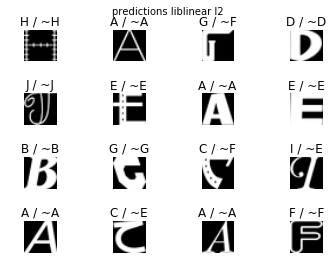

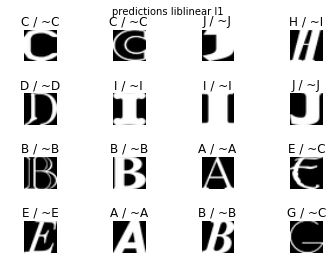

AttributeError: 'list' object has no attribute 'shape'

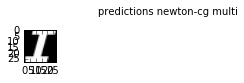

In [15]:
for model in models:
    display_sample(test_dataset, test_labels, 'predictions ' + model[0], model[1])

Data set of sizes ('Training', (89998, 28, 28), (89998,)) ('Validation', (10000, 28, 28), (10000,))
--------


#### Results for original dataset:
on test dataset:
scoring newton-cg multi
0.887951292459
scoring liblinear l2
0.884693441572
scoring liblinear l1
0.885921811579
scoring sag l2
0.884640034181
scoring lbfgs multi ((our winner: time vs accuracy))
0.887897885067

on validation dataset:
scoring liblinear l2
0.8178
scoring liblinear l1
0.8186
scoring sag l2
0.8179
scoring newton-cg multi
0.8242


#### Results for deduped dataset
test dataset:
scoring liblinear l2
0.882522602474
scoring liblinear l1
0.883964723501
scoring newton-cg multi
0.885628709302
scoring lbfgs multi
0.885739641688
scoring sag l2
0.882578068667


validation dataset:
scoring liblinear l2
0.796029536376
scoring liblinear l1
0.798692652221
scoring newton-cg multi
0.802203123109
scoring lbfgs multi
0.802566275269
scoring sag l2
0.796029536376
